In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

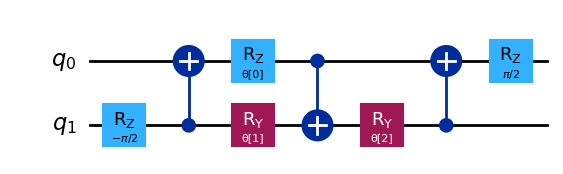

In [2]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
 target = QuantumCircuit(2)
 target.rz(-np.pi / 2, 1)
 target.cx(1, 0)
 target.rz(params[0], 0)
 target.ry(params[1], 1)
 target.cx(0, 1)
 target.ry(params[2], 1)
 target.cx(1, 0)
 target.rz(np.pi / 2, 0)
 return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

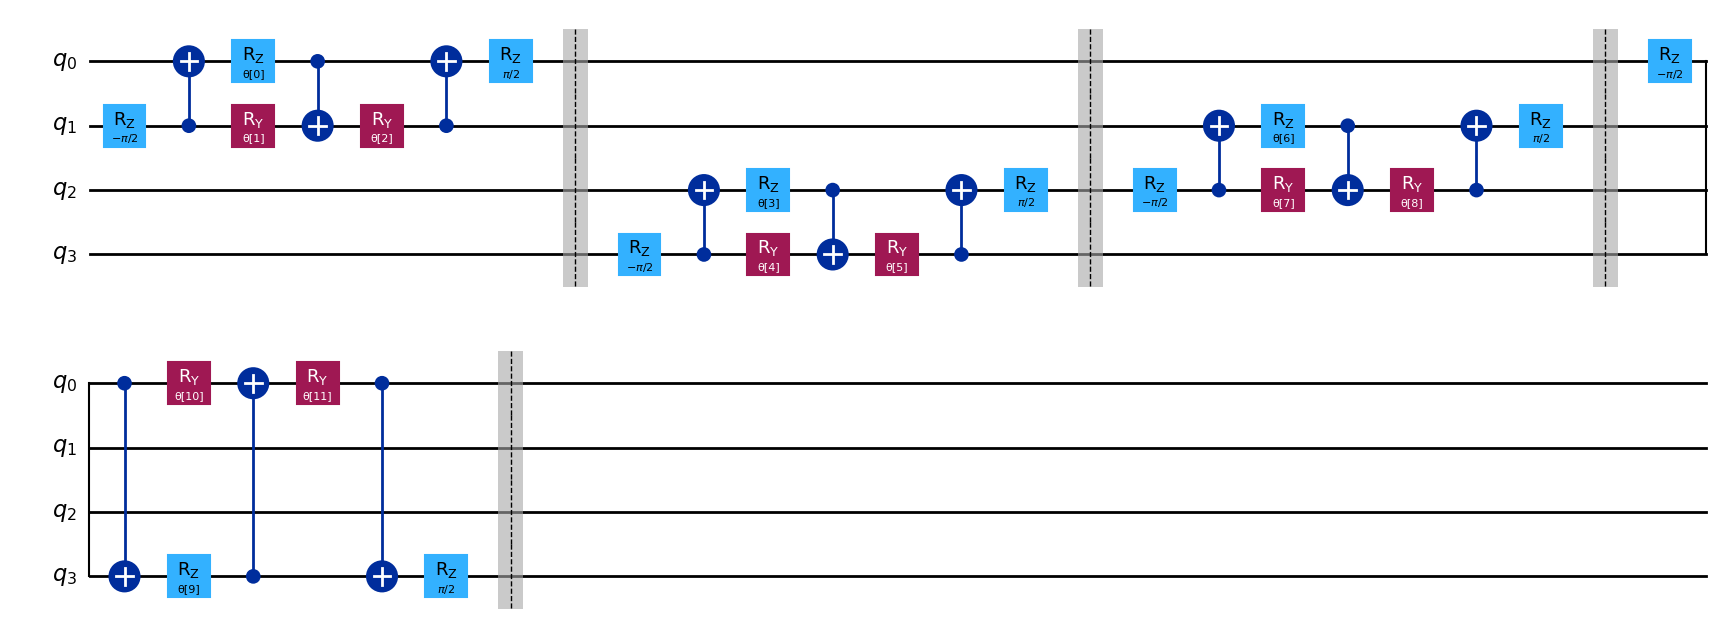

In [3]:
def conv_layer(num_qubits, param_prefix):
 qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
 qubits = list(range(num_qubits))
 param_index = 0
 params = ParameterVector(param_prefix, length=num_qubits * 3)
 for q1, q2 in zip(qubits[0::2], qubits[1::2]):
 qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
 qc.barrier()
 param_index += 3
 for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
 qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
 qc.barrier()
 param_index += 3

 qc_inst = qc.to_instruction()

 qc = QuantumCircuit(num_qubits)
 qc.append(qc_inst, qubits)
 return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

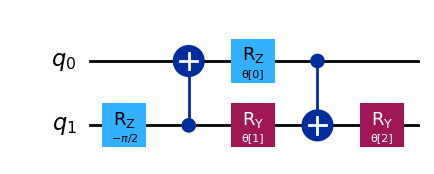

In [4]:
def pool_circuit(params):
 target = QuantumCircuit(2)
 target.rz(-np.pi / 2, 1)
 target.cx(1, 0)
 target.rz(params[0], 0)
 target.ry(params[1], 1)
 target.cx(0, 1)
 target.ry(params[2], 1)

 return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

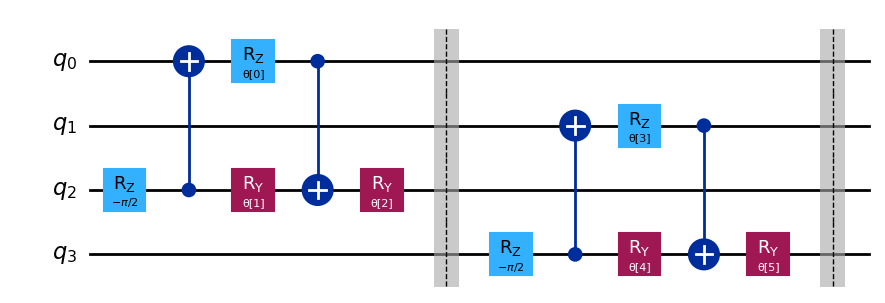

In [5]:
def pool_layer(sources, sinks, param_prefix):
 num_qubits = len(sources) + len(sinks)
 qc = QuantumCircuit(num_qubits, name="Pooling Layer")
 param_index = 0
 params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
 for source, sink in zip(sources, sinks):
 qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
 qc.barrier()
 param_index += 3

 qc_inst = qc.to_instruction()

 qc = QuantumCircuit(num_qubits)
 qc.append(qc_inst, range(num_qubits))
 return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
def filter_3649(x, y):
 keep = (y == 3) | (y == 6)| (y == 4)
 x, y = x[keep], y[keep]
 # y = y == 3
 return x,y

In [8]:
x_train, y_train = filter_3649(x_train, y_train)
x_test, y_test = filter_3649(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 17891
Number of filtered test examples: 2950


4


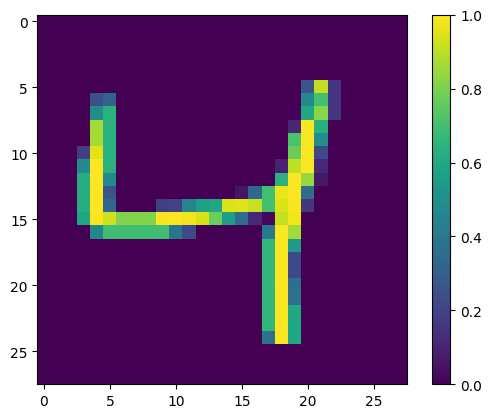

In [9]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

4


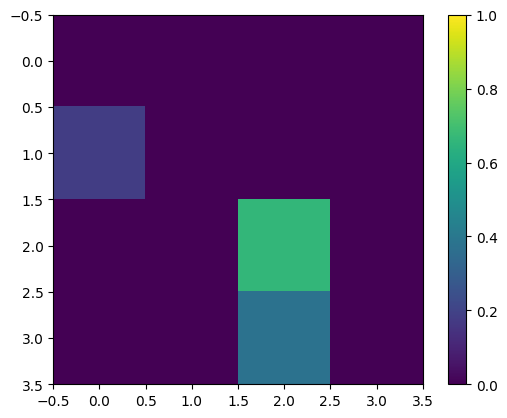

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
 mapping = collections.defaultdict(set)
 orig_x = {}
 # Determine the set of labels for each unique image:
 for x,y in zip(xs,ys):
 orig_x[tuple(x.flatten())] = x
 mapping[tuple(x.flatten())].add(y)
 
 new_x = []
 new_y = []
 for flatten_x in mapping:
 x = orig_x[flatten_x]
 labels = mapping[flatten_x]
 if len(labels) == 1:
 new_x.append(x)
 new_y.append(next(iter(labels)))
 else:
 # Throw out images that match more than one label.
 pass

 num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and 3 in value)
 num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and 6 in value)
 num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and 4 in value)
 num_uniq_9 = sum(1 for value in mapping.values() if len(value) == 1 and 9 in value)
 num_uniq_both = sum(1 for value in mapping.values() if len(value) >= 2)

 print("Number of unique images:", len(mapping.values()))
 print("Number of unique 3s: ", num_uniq_3)
 print("Number of unique 6s: ", num_uniq_6)
 print("Number of unique 4s: ", num_uniq_4)
 print("Number of unique 9s: ", num_uniq_9)
 print("Number of unique contradicting labels: ", num_uniq_both)
 print()
 print("Initial number of images: ", len(xs))
 print("Remaining non-contradicting unique images: ", len(new_x))
 
 return np.asarray(new_x), np.asarray(new_y)

In [13]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 15618
Number of unique 3s: 4773
Number of unique 6s: 5364
Number of unique 4s: 5231
Number of unique 9s: 0
Number of unique contradicting labels: 250

Initial number of images: 17891
Remaining non-contradicting unique images: 15368
Number of unique images: 2736
Number of unique 3s: 866
Number of unique 6s: 903
Number of unique 4s: 938
Number of unique 9s: 0
Number of unique contradicting labels: 29

Initial number of images: 2950
Remaining non-contradicting unique images: 2707


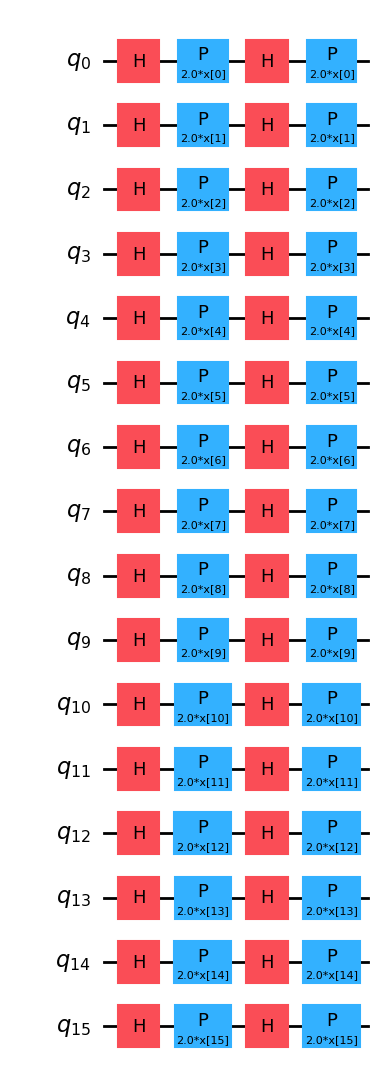

In [14]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [15]:
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# # Fourth Convolutional Layer
# ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# # Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])



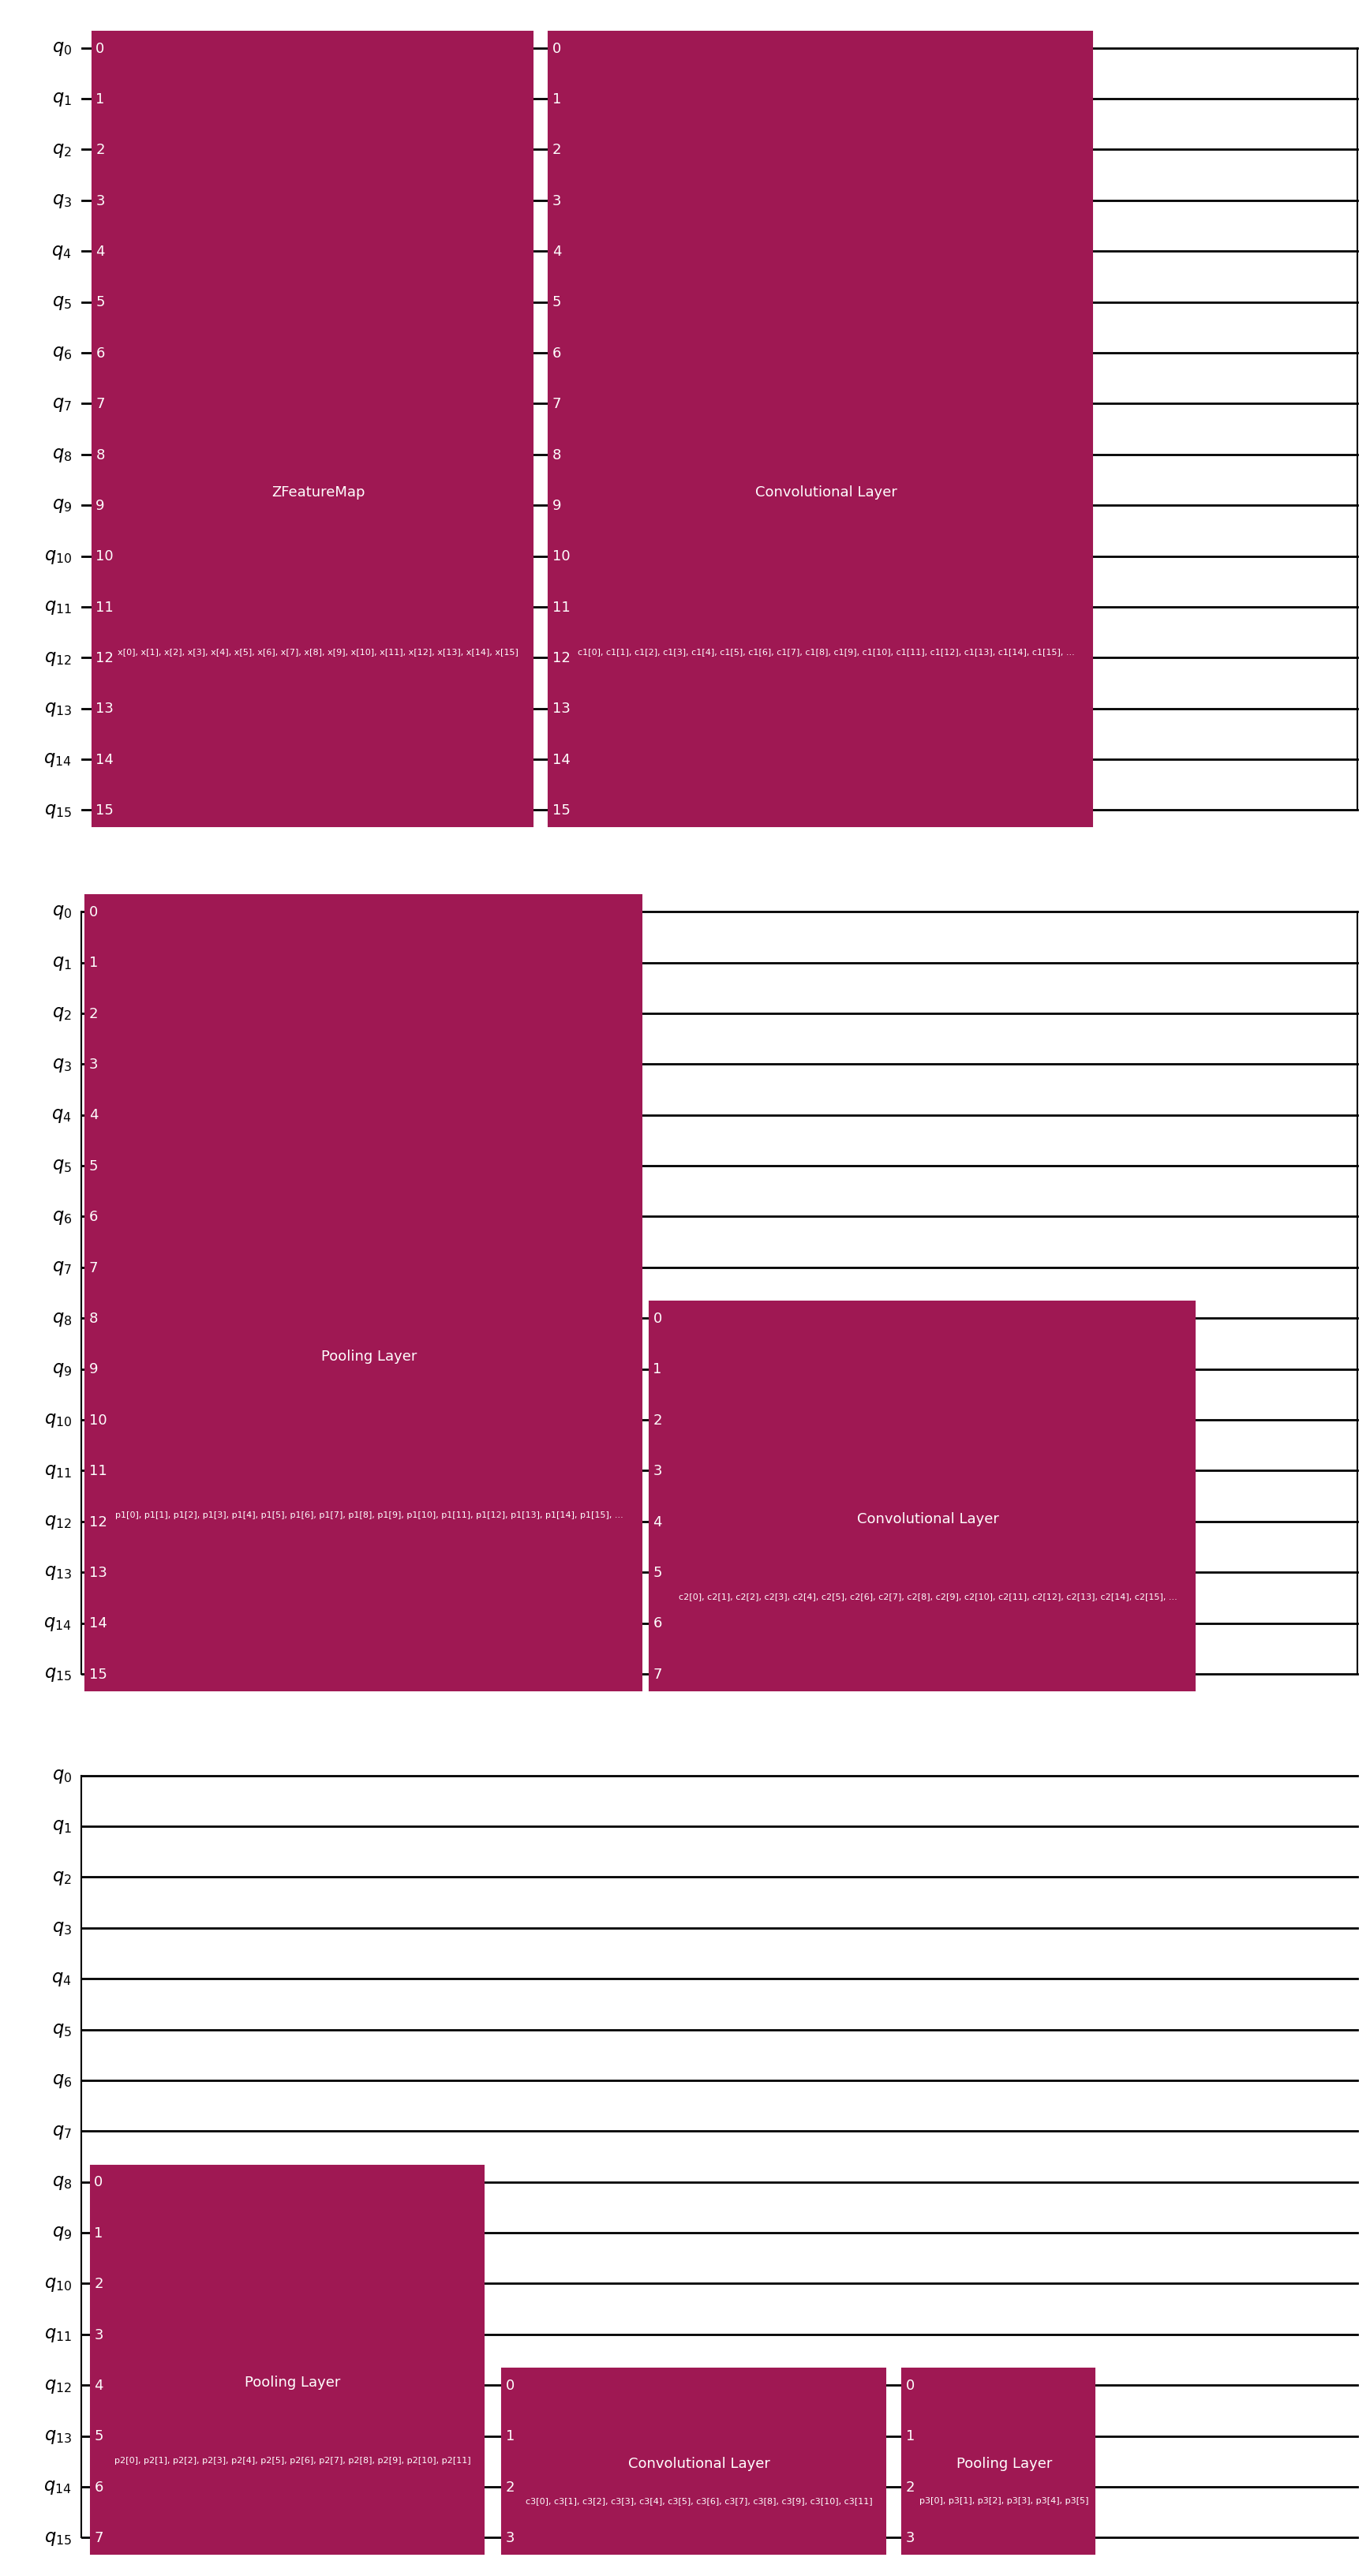

In [16]:
circuit.draw("mpl")

In [17]:
def callback_graph(weights, obj_func_eval):
 clear_output(wait=True)
 objective_func_vals.append(obj_func_eval)
 
 
 print("weights", weights)
 print("objective function value", objective_func_vals)
 
 plt.title("Objective function value against iteration")
 plt.xlabel("Iteration")
 plt.ylabel("Objective function value")
 plt.plot(range(len(objective_func_vals)), objective_func_vals)
 plt.show()

In [18]:
# construct variational quantum classifier
classifier = VQC(
 feature_map=feature_map.decompose(),
 ansatz=ansatz.decompose(),
 optimizer=COBYLA(maxiter=30, tol=1, rhobeg=20),
 callback=callback_graph,
 initial_point = weights
)

In [19]:
# y_int = []
# for a in train_labels:
# if a:
# y_int.append(1)
# else: 
# y_int.append(-1)
 
# y1_int = []
# for a in test_labels:
# if a:
# y1_int.append(1)
# else: 
# y1_int.append(-1)

x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
 x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
 x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
 #print("entry \n" , entry[0])
 final_x.append(entry[0])

for entry in x1_reshaped:
 #print("entry \n" , entry[0])
 final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[:100]
y = y[:100]

print(x)
print(y)

# def convert_to_onehot(arr):
# encoded_arr = np.zeros((arr.size, arr.max()+1), dtype=int)
# encoded_arr[np.arange(arr.size),arr] = 1
# print(encoded_arr)


# y = convert_to_onehot(y)

[[0. 0. 0. ... 0. 0.3764706 0. ]
 [0. 0. 0. ... 0.6745098 0. 0. ]
 [0. 0. 0. ... 0.6039216 0.19215687 0. ]
 ...
 [0. 0. 0. ... 0. 0. 0. ]
 [0. 0. 0. ... 0. 0.83137256 0. ]
 [0. 0. 0. ... 0.04705882 0. 0. ]]
[4 3 3 6 6 4 4 3 3 6 6 6 3 3 4 4 4 4 6 4 6 6 3 6 3 4 6 4 6 3 6 3 3 4 6 4 6
 3 4 3 4 4 6 3 4 6 6 3 4 4 6 4 3 6 4 3 3 6 3 3 4 6 6 4 3 4 6 6 3 3 3 3 6 4
 6 4 4 6 4 3 3 6 4 3 4 4 3 6 6 6 4 4 3 6 4 4 3 4 4 3]


weights [2.41670560e-01 2.97258993e+00 2.16295826e+01 2.13417996e+01
 1.56689462e+00 2.04899173e+01 2.10437709e+01 1.12333610e+00
 7.83274760e-01 5.62203330e-01 1.33130938e+00 2.03367116e+01
 9.41710590e-01 1.11078689e+00 2.01636380e+01 7.07180500e-01
 2.83367170e-01 1.52974035e+00 6.93831850e-01 2.14079034e+01
 1.59628412e+00 2.00984718e+01 1.55130730e-01 1.78939370e+00
 6.97461940e-01 1.79985820e+00 5.05555100e-01 6.06919360e-01
 2.18656661e+01 2.32211500e-02 1.74235120e-01 5.74737890e-01
 1.23557740e-01 9.25938360e-01 5.87020200e-01 3.51708840e-01
 3.83710420e-01 5.01483300e-02 2.15523180e-01 2.94441000e-02
 1.83593760e-01 3.31878800e-01 7.22046700e-02 8.36934750e-01
 5.63091170e-01 1.58453500e-02 9.51629150e-01 2.04537970e-01
 3.28920350e-01 8.65273360e-01 6.21196490e-01 5.13673160e-01
 2.43329770e-01 9.40251700e-02 8.76995000e-03 6.01025540e-01
 7.34953590e-01 7.78407610e-01 5.38165200e-01 4.19350100e-02
 4.39680430e-01 2.97403450e-01 2.77780260e-01 5.90384670e-01
 2.04362020e-01 

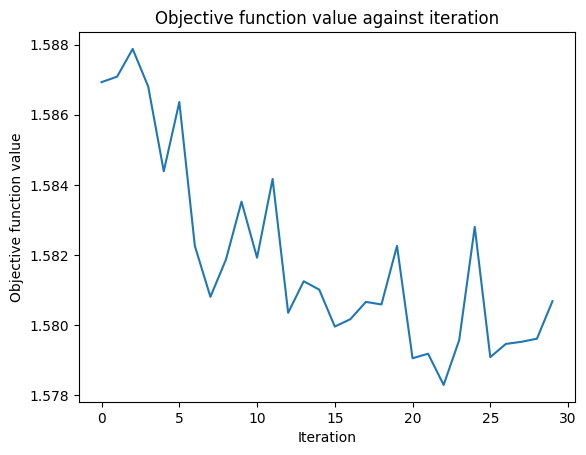

Accuracy from the train data : 54.0%


In [20]:
classifier.fit(x, y)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [21]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
 
x1 = x1[:50]
y1 = y1[:50]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 44.0%


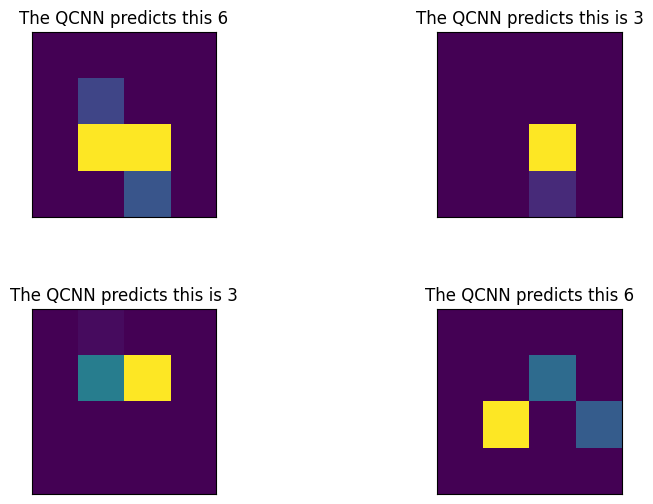

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
 ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
 if y_predict[i] == 3:
 ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
 if y_predict[i] == 6:
 ax[i // 2, i % 2].set_title("The QCNN predicts this 6")
 if y_predict[i] == 4:
 ax[i // 2, i % 2].set_title("The QCNN predicts this 4") 
 if y_predict[i] == 9:
 ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)